# Lesson 3 - Random forest deep dive

> A deep dive into how Random Forests work and some tricks for making them more performant.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/hepml/master?urlpath=lab/tree/notebooks%2Flesson03_random-forest-from-scratch.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lewtun/hepml/blob/master/notebooks/lesson03_random-forest-from-scratch.ipynb)

## Learning objectives

## References

## The data

We will continue our analysis of the [SUSY dataset](http://archive.ics.uci.edu/ml/datasets/SUSY#) from lesson 1, but this time start from our prepared training and test sets:

* `susy_train.feather`
* `susy_test.feather`

By using the [Feather format](https://blog.rstudio.com/2016/03/29/feather/) we can load our data in a fraction of the time compared to CSV.

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# uncomment this if running locally or on Google Colab
# !pip install --upgrade hepml

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from pathlib import Path
from hepml.core import display_large, download_dataset

# data viz
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# ml magic
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Load the data

As usual, we can download our datasets by using our `download_dataset` helper function:

In [ ]:
download_dataset("susy_train.feather")
download_dataset("susy_test.feather")

Dataset already exists at '../data/susy_train.feather' and is not downloaded again.
Dataset already exists at '../data/susy_test.feather' and is not downloaded again.


In [ ]:
DATA = Path("../data")
!ls {DATA}

susy.csv.gz        susy.feather       susy_test.feather  susy_train.feather


With pathlib it is a simple matter to define the filepath to the dataset, and since the file is in Feather format we can load it as a `pandas.DataFrame` as follows:

In [ ]:
susy_train = pd.read_feather(DATA / "susy_train.feather")
susy_train.head()

,signal,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [ ]:
susy_sample = susy_train.sample(n=100000, random_state=42).reset_index(drop=True)
susy_sample = susy_sample[["missing energy magnitude", "lepton 1 pT", "signal"]].copy()

In [ ]:
X = susy_sample.drop("signal", axis=1)
y = susy_sample["signal"]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Dataset split: {len(X_train)} train rows + {len(X_valid)} valid rows")

Dataset split: 80000 train rows + 20000 valid rows


## Basic data structures

In [ ]:
class TreeEnsemble:
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x, self.y, self.sample_sz, self.min_leaf = x, y, sample_sz, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[: self.sample_sz]
        return DecisionTree(
            self.x.iloc[rnd_idxs], self.y.iloc[rnd_idxs], min_leaf=self.min_leaf
        )

    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

In [ ]:
class DecisionTree:
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf

In [ ]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [ ]:
m.trees

In [ ]:
def gini_impurity(y):
    return 1 - np.sum((np.unique(y, return_counts=True)[1] / len(y)) ** 2)

In [ ]:
gini_impurity(y_train)

0.49644253875

In [ ]:
y_train[0:1].value_counts().values

array([1])

In [ ]:
np.array([1.0, 0.0])[0]

1.0

In [ ]:
y_train.value_counts(normalize=True).values.all() > 1

False

In [ ]:
class DecisionTree:
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None:
            idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        self.n, self.c = len(idxs), x.shape[1]
        counts = y.iloc[idxs].value_counts(normalize=True).values
        if len(counts) == 1:
            if int(y.iloc[idxs].values[0]) == 0:
                self.val = np.array([1.0, 0.0])
            else:
                self.val = np.array([0., 1.0])
        else:
            self.val = counts
        self.gini = gini_impurity(y)
        self.score = float("inf")
        self.find_varsplit()

    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)

    # We'll write this later!
    def find_better_split(self, var_idx):
        pass

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float("inf")

    def __repr__(self):
        s = f"n: {self.n}; val:{self.val}; gini: {self.gini}"
        if not self.is_leaf:
            s += f"; score:{self.score}; split:{self.split}; var:{self.split_name}"
        return s

In [ ]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [ ]:
m.trees[0]

n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004

In [ ]:
m.trees[0]

n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004

## Single branch

### Find best split given variable

In [ ]:
ens = TreeEnsemble(X_train, y_train, 1, 1000)
tree = ens.trees[0]
x_samp, y_samp = tree.x, tree.y
x_samp.columns

Index(['missing energy magnitude', 'lepton 1 pT'], dtype='object')

In [ ]:
x_samp

,missing energy magnitude,lepton 1 pT
94532,0.918918,1.057334
18306,0.634309,0.577473
22250,1.021825,0.388739
25757,0.621383,1.099195
4650,0.624848,1.427718
...,...,...
94847,2.322613,3.574648
22390,0.380953,0.630820
54426,0.306178,0.344770
24105,0.888237,0.629380


In [ ]:
tree

n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004

In [ ]:
m = RandomForestClassifier(
    n_estimators=1, max_depth=1, bootstrap=False, random_state=42, max_features=None
)
m.fit(x_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

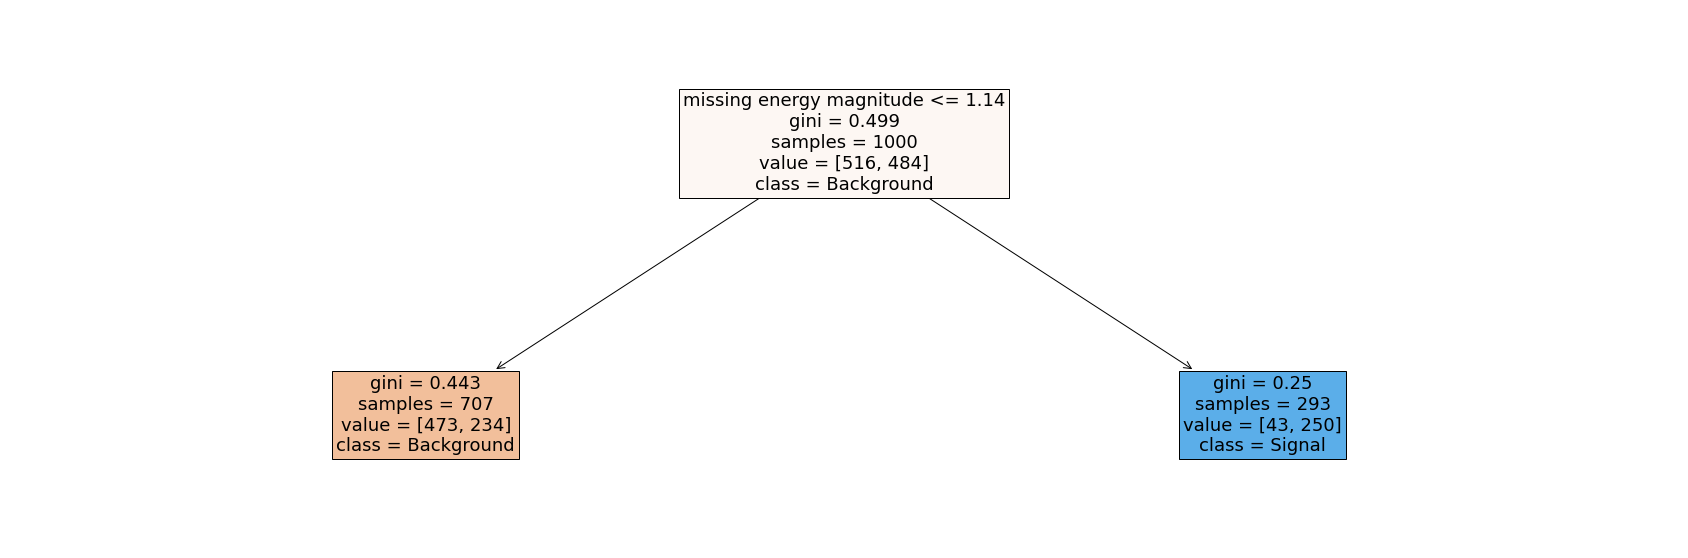

In [ ]:
# get column names
feature_names = X_train.columns
# define class names
class_names = ["Background", "Signal"]
# we need to specify the background color because of a quirk in sklearn
fig, ax = plt.subplots(figsize=(30, 10))
# generate tree plot
plot_tree(
    m.estimators_[0],
    filled=True,
    feature_names=feature_names,
    class_names=class_names,
    ax=ax,
    fontsize=18,
)
plt.show()

In [ ]:
%timeit gini_impurity(y_train)

1.56 ms ± 19.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%timeit y_train.value_counts().values / len(y_train)

1.26 ms ± 7.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
%timeit np.unique(y_train, return_counts=True)[1] / len(y_train)

1.24 ms ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
1 - np.sum((y_samp.value_counts() / len(y_samp)) ** 2)

0.49948800000000004

In [ ]:
def find_better_split(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y.iloc[self.idxs]

    for i in range(self.n):
        lhs = x <= x[i]
        rhs = x > x[i]
        if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf:
            continue
        lhs_std = gini_impurity(y[lhs])
        rhs_std = gini_impurity(y[rhs])
        curr_score = lhs_std * len(y[lhs]) / len(y) + rhs_std * len(y[rhs]) / len(y)
        if curr_score < self.score:
            self.var_idx, self.score, self.split, self.gini = (
                var_idx,
                curr_score,
                x[i],
                gini_impurity(y),
            )

In [ ]:
%timeit find_better_split(tree,1)
tree

4.22 s ± 50.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


n: 1000; val:[516 484]; gini: 0.49948800000000004; score:0.3864820927729048; split:1.1392959356307983; var:missing energy magnitude

In [ ]:
find_better_split(tree, 0)
tree

n: 1000; val:[516 484]; gini: 0.49948800000000004; score:0.3864820927729048; split:1.1392959356307983; var:missing energy magnitude

## Speeding things up

In [ ]:
tree = TreeEnsemble(X_train, y_train, 1, 1000).trees[0]

In [ ]:
def find_better_split(self, var_idx):
    x, y = self.x.values[self.idxs, var_idx], self.y.values[self.idxs]

    sort_idx = np.argsort(x)
    sort_y, sort_x = y[sort_idx], x[sort_idx]
    id_counter = 0

    for i in range(0, self.n - self.min_leaf):
        id_counter += 1
        xi, yi = sort_x[i], sort_y[i]
        if i < self.min_leaf - 1 or xi == sort_x[i + 1]:
            continue

        lhs_std = gini_impurity(sort_y[:id_counter])
        rhs_std = gini_impurity(sort_y[id_counter:])
        curr_score = lhs_std * len(sort_y[:id_counter]) / len(sort_y) + rhs_std * len(
            sort_y[id_counter:]
        ) / len(sort_y)
        if curr_score < self.score:
            self.var_idx, self.score, self.split, self.gini = (
                var_idx,
                curr_score,
                xi,
                gini_impurity(y),
            )

In [ ]:
%timeit find_better_split(tree,1)
tree

67.1 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004; score:0.406274337005304; split:0.8724983930587769; var:lepton 1 pT

In [ ]:
find_better_split(tree, 0)
tree

n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004; score:0.3864820927729048; split:1.1392959356307983; var:missing energy magnitude

In [ ]:
DecisionTree.find_better_split = find_better_split

In [ ]:
tree = TreeEnsemble(X_train, y_train, 1, 1000).trees[0]
tree

n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004; score:0.3864820927729048; split:1.1392959356307983; var:missing energy magnitude

## Full single tree

In [ ]:
m = RandomForestClassifier(
    n_estimators=1, max_depth=2, bootstrap=False, random_state=42, max_features=None
)
m.fit(x_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

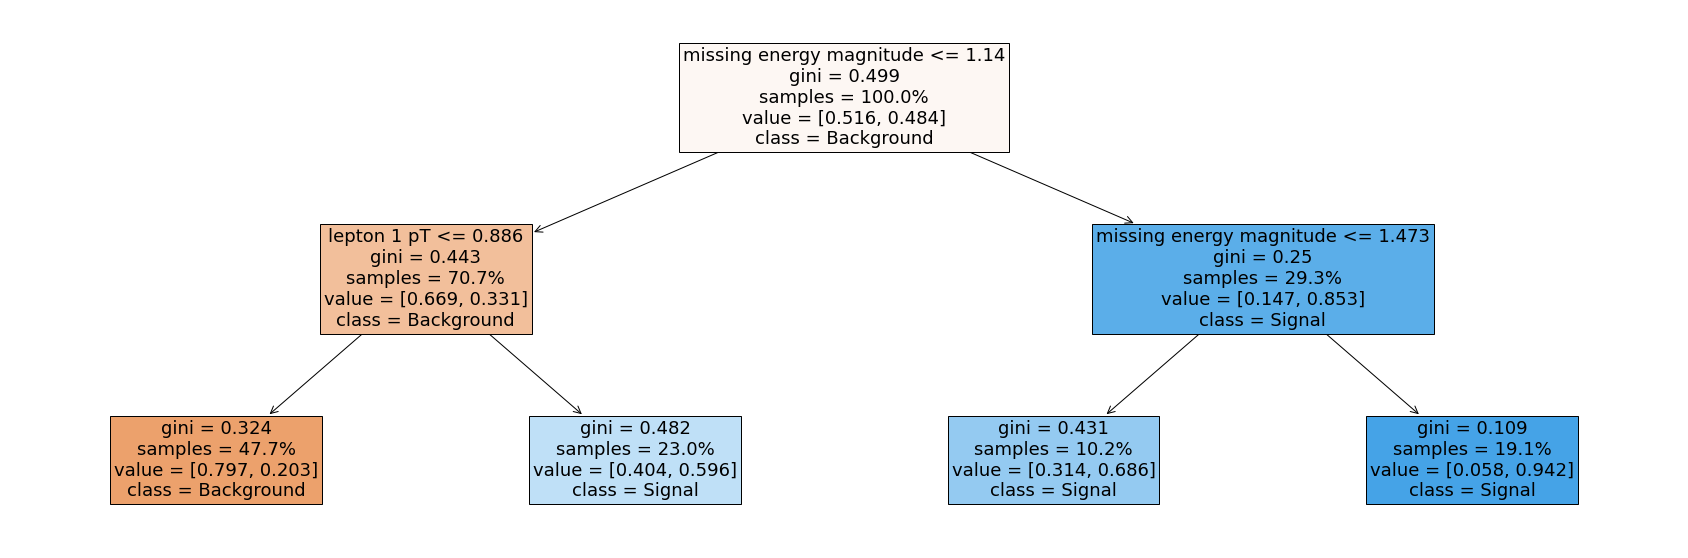

In [ ]:
# get column names
feature_names = X_train.columns
# define class names
class_names = ["Background", "Signal"]
# we need to specify the background color because of a quirk in sklearn
fig, ax = plt.subplots(figsize=(30, 10))
# generate tree plot
plot_tree(
    m.estimators_[0],
    filled=True,
    feature_names=feature_names,
    class_names=class_names,
    ax=ax,
    fontsize=18,
    proportion=True
)
plt.show()

In [ ]:
def find_varsplit(self):
    for i in range(self.c):
        self.find_better_split(i)
    if self.is_leaf:
        return
    x = self.split_col
    lhs = np.nonzero(x <= self.split)[0]
    rhs = np.nonzero(x > self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

In [ ]:
DecisionTree.find_varsplit = find_varsplit

In [ ]:
a, b = np.unique(np.array([0, 0,]), return_counts=True)

In [ ]:
if len(a) == 1:
    if int(a) == 0:
        print(np.array([0., 1.]))

[0. 1.]


In [ ]:
tree = TreeEnsemble(x_samp, y_samp, 1, 1000).trees[0]
tree

n: 1000; val:[0.516 0.484]; gini: 0.49948800000000004; score:0.3864820927729048; split:1.1392959356307983; var:missing energy magnitude

In [ ]:
tree.lhs

n: 707; val:[0.66902405 0.33097595]; gini: 0.4428617442467625; score:0.3753049089041096; split:0.8853832483291628; var:lepton 1 pT

In [ ]:
tree.rhs

n: 293; val:[0.85324232 0.14675768]; gini: 0.2504397255646542; score:0.22066400314213208; split:1.4726196527481081; var:missing energy magnitude

In [ ]:
tree.lhs.lhs

n: 477; val:[0.7966457 0.2033543]; gini: 0.32400265460666544; score:0.3118973109371423; split:0.7281696796417235; var:lepton 1 pT

In [ ]:
tree.lhs.rhs

n: 230; val:[0.59565217 0.40434783]; gini: 0.4817013232514178; score:0.4334455110107284; split:1.5821422338485713; var:lepton 1 pT

## Predictions

In [ ]:
%time tree = TreeEnsemble(X_train, y_train, 1, 1000).trees[0]
x_samp, y_samp = tree.x, tree.y

CPU times: user 1.41 s, sys: 1.63 ms, total: 1.41 s
Wall time: 1.41 s


In [ ]:
m = RandomForestClassifier(
    n_estimators=1,
    max_depth=None,
    bootstrap=False,
    max_features=None,
    random_state=42,
    min_samples_leaf=5
)
m.fit(x_samp, y_samp)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

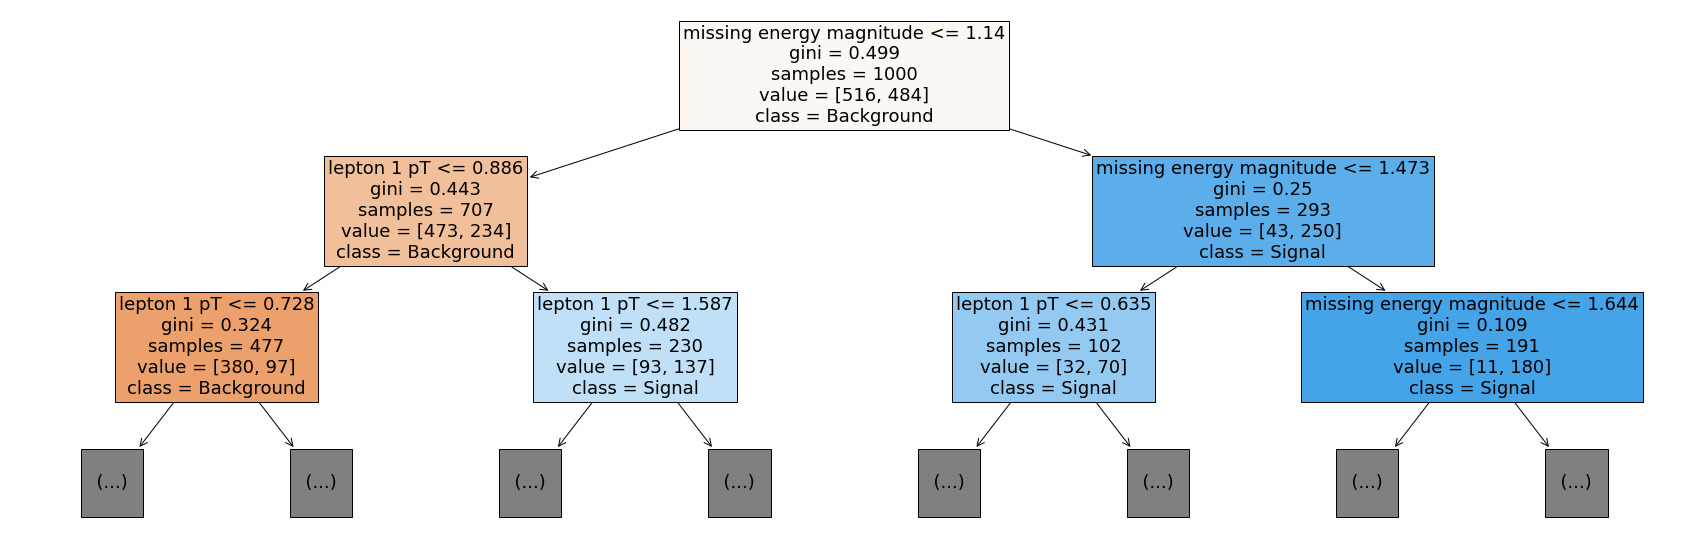

In [ ]:
# get column names
feature_names = X_train.columns
# define class names
class_names = ["Background", "Signal"]
# we need to specify the background color because of a quirk in sklearn
fig, ax = plt.subplots(figsize=(30, 10))
# generate tree plot
plot_tree(
    m.estimators_[0],
    max_depth=2,
    filled=True,
    feature_names=feature_names,
    class_names=class_names,
    ax=ax,
    fontsize=18,
)
plt.show()

In [ ]:
m.predict(X_valid.iloc[0:10, :])

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 0.])

In [ ]:
m.predict_proba(X_valid.iloc[0:10, :])

array([[1.        , 0.        ],
       [0.8       , 0.2       ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.71428571, 0.28571429],
       [0.8       , 0.2       ]])

In [ ]:
def predict(self, x):
    return np.array([self.predict_row(xi) for xi in x])

DecisionTree.predict = predict

In [ ]:
def predict_row(self, xi):
    if self.is_leaf:
        return np.argmax(self.val)
    t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

In [ ]:
my_preds = tree.predict(X_valid.values)

In [ ]:
sk_preds = m.predict(X_valid)

In [ ]:
my_preds[:20]

array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [ ]:
sk_preds[:20]

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 0.])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
accuracy_score(y_valid, my_preds)

0.6971

In [ ]:
accuracy_score(y_valid, sk_preds)

0.7116

In [ ]:
confusion_matrix(sk_preds, my_preds, normalize='true')

array([[0.99860595, 0.00139405],
       [0.48170996, 0.51829004]])

In [ ]:
X_valid.values

array([[0.44825193, 0.68398368],
       [0.58317357, 1.07188785],
       [0.34072012, 0.51047599],
       ...,
       [0.99937689, 0.95501542],
       [1.09224701, 0.69372141],
       [0.81261975, 1.06015122]])

In [ ]:
np.unique(preds)

array([0])

In [ ]:
tree.lhs.lhs.lhs.is_leaf

False